# TikTok Claims Classification

This project is completed as part of the Google Advanced Analytics Course. The data set is a (presumably) artifical dataset conatining information about flagged TikTok videos and whether they are a include a "Claim" made by the author or express an "Opinion".


With the number of submissions and interactions on TikTok each day, it’s challenging to manually review each video, user comment, and content claim. Thus, the goal of this project is to develop a predictive model that can determine whether a video contains a claim or offers an opinion.




In [1]:
# Import packages for data manipulation
import pandas as pd
import numpy as np

# Import packages for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Import packages for data preprocessing
from sklearn.feature_extraction.text import CountVectorizer

# Import packages for data modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, precision_score, \
recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay



from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, plot_importance

In [2]:
# Load dataset into dataframe
data = pd.read_csv("tiktok_dataset.csv")

In [3]:
data.sample(5)

# claim_status    video_id  video_duration_sec  \
7838    7839        claim  9470214242                  37   
12546  12547      opinion  9973279428                  51   
13300  13301      opinion  2085281748                  32   
3457    3458        claim  9848838269                  18   
9904    9905      opinion  2221819043                   5   

                                video_transcription_text verified_status  \
7838   someone located a report claiming that dogs ca...    not verified   
12546  our opinion is that some trees in melbourne ha...    not verified   
13300  our belief is that armadillos have bulletproof...    not verified   
3457   someone learned  on a website that an octopus ...    not verified   
9904   i feel that vinyl record sales now surpass com...        verified   

      author_ban_status  video_view_count  video_like_count  \
7838             active          263729.0           91517.0   
12546            active            4421.0            1345.0   
13300            active              87.0              20.0   
3457             banned          562417.0          211909.0   
9904             active            9493.0            3217.0   

       video_share_count  video_download_count  video_comment_count  
7838             28090.0                1211.0                178.0  
12546              267.0                  27.0                  4.0  
13300                1.0                   0.0                  0.0  
3457             42996.0                1843.0                854.0  
9904               330.0                   0.0                  0.0

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19382 entries, 0 to 19381
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   #                         19382 non-null  int64  
 1   claim_status              19084 non-null  object 
 2   video_id                  19382 non-null  int64  
 3   video_duration_sec        19382 non-null  int64  
 4   video_transcription_text  19084 non-null  object 
 5   verified_status           19382 non-null  object 
 6   author_ban_status         19382 non-null  object 
 7   video_view_count          19084 non-null  float64
 8   video_like_count          19084 non-null  float64
 9   video_share_count         19084 non-null  float64
 10  video_download_count      19084 non-null  float64
 11  video_comment_count       19084 non-null  float64
dtypes: float64(5), int64(3), object(4)
memory usage: 1.8+ MB


In [5]:
(data.isna().sum(axis=1) != 0).sum()

298

We see that 298 rows are missing data. And any columns missing data are missing 298 values. Thus is any rows has a null value its has a null for all 7 of the columns that are not complete. These columns most of the intersting information, and in particular its missing our target variable, so keeping them will not be useful. Lets drop them them outright.

In [6]:
#Drop Nulls
data.dropna(inplace=True)

In [7]:
#Check duplicates
data.duplicated().sum()

0

In [8]:
# check balance
data["claim_status"].value_counts(normalize=True)

claim      0.503458
opinion    0.496542
Name: claim_status, dtype: float64

We are almost exactly 50/50, so are dataset is balanced.

# Begin EDA

From a quick look at our dataset, we have mostly numeric data. There are aklso a few categorical variables, as well as the transaction text. I wont at the moment dive into any advanced NLP, so the text content itself wont matter much, but perhaps the length of the text can be informative.

In [9]:
# Create `text_length` column
data['text_length'] = data['video_transcription_text'].str.len()

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


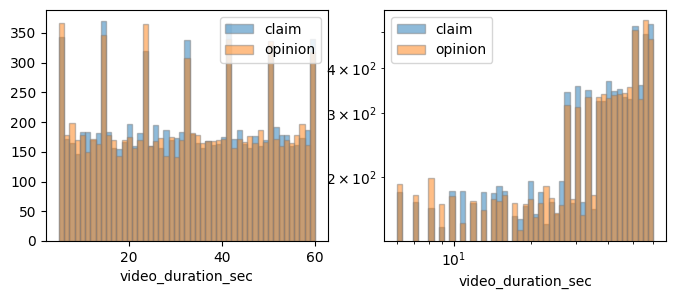

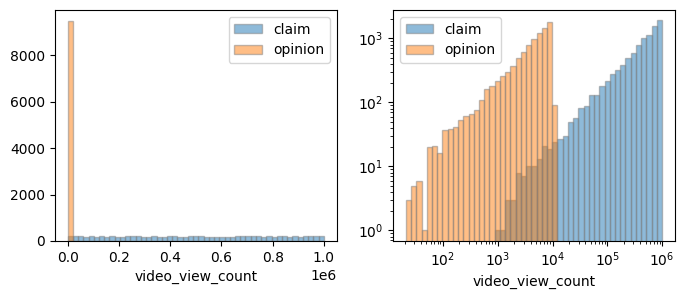

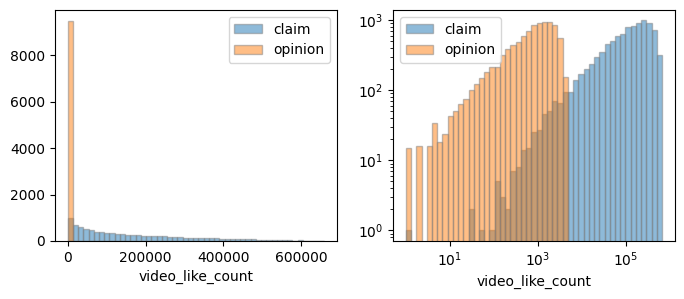

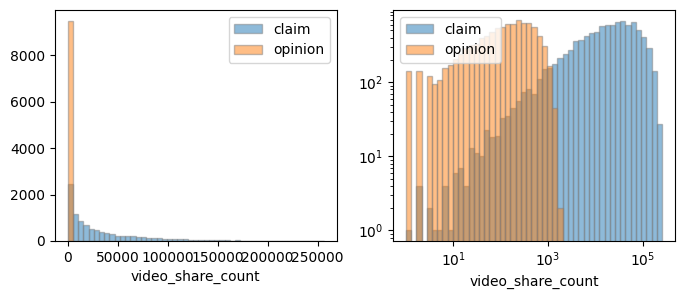

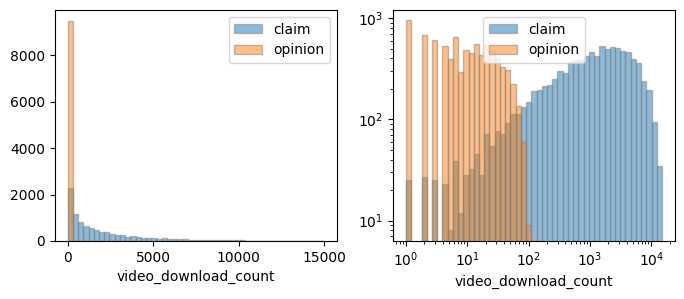

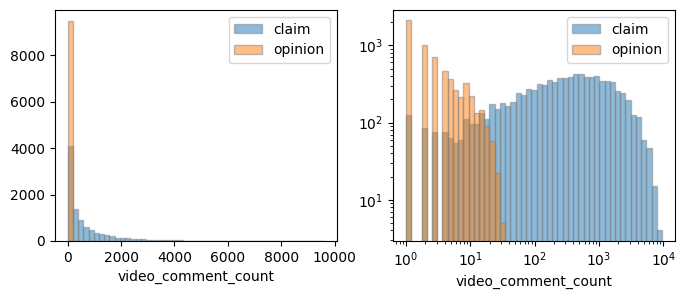

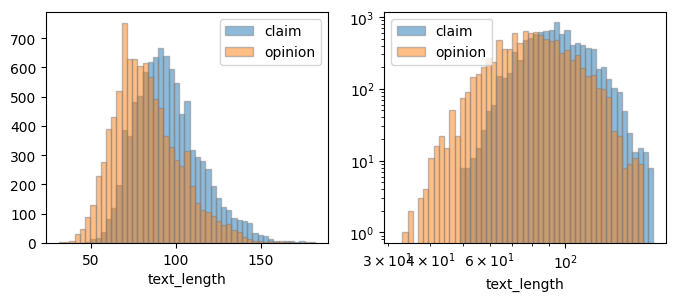

In [10]:
#list of numerical columns
num_cols = [ 'video_duration_sec',
       'video_view_count', 'video_like_count', 'video_share_count',
       'video_download_count', 'video_comment_count', 'text_length']

for col in num_cols:
    fig, axes = plt.subplots(1, 2, figsize=(8,3))


    bins = np.linspace(np.nanmin(data[col]), np.nanmax(data[col]), 50)
    axes[0].hist(data[data['claim_status']=='claim'][col], label='claim', bins=bins, alpha=0.5, edgecolor='grey')
    axes[0].hist(data[data['claim_status']=='opinion'][col], label='opinion', bins=bins, alpha=0.5, edgecolor='grey')
    axes[0].legend()
    axes[0].set_xlabel(col)

    axes[1].loglog()
    bins = np.logspace(np.nanmin(np.log10(data[col]+1)), np.nanmax(np.log10(data[col])), 50)
    axes[1].hist(data[data['claim_status']=='claim'][col], label='claim', bins=bins, alpha=0.5, edgecolor='grey')
    axes[1].hist(data[data['claim_status']=='opinion'][col], label='opinion', bins=bins, alpha=0.5, edgecolor='grey')
    axes[1].legend()
    axes[1].set_xlabel(col)

Very clearly the Claims vs Opinions are differently distributed in these parameters. Some pretty stark discrepancies can be seen in particular in video views and likes. Viewing the distributions in logspace make these different distributions much more clear. This gives us some idea of how the target variable is related to these otherproperties. Lets also take a quick look at the correlation between the numeric features.

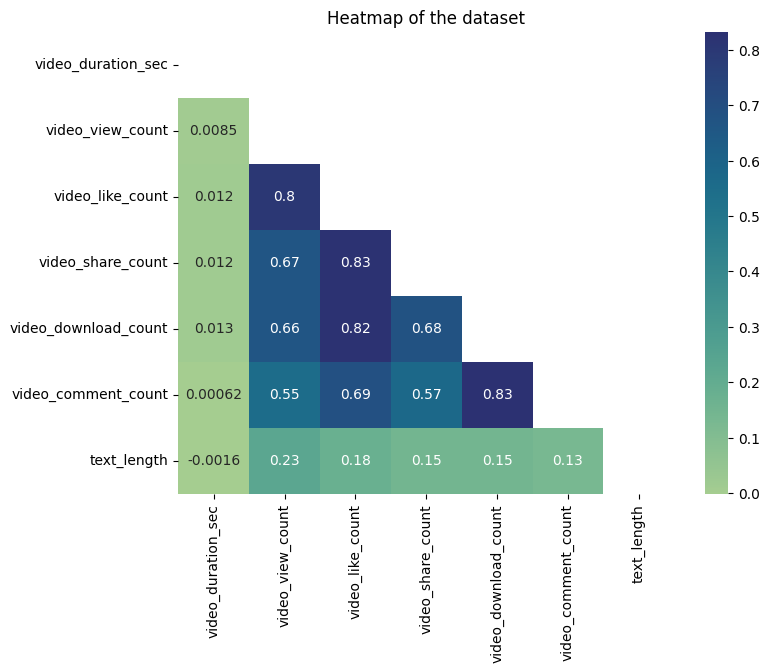

In [11]:
corr = data[num_cols].corr(numeric_only=True)

trimask = np.triu(np.ones_like(corr, dtype=bool))

# Create a heatmap to visualize how correlated variables are
plt.figure(figsize=(8, 6))
sns.heatmap(corr,
    annot=True,
    cmap="crest", mask=trimask)
plt.title("Heatmap of the dataset")
plt.show()


Here we see some strongly correlated parameters, specifically the interaction parameters such as shares, likes, and download. I dfind it a bit surprising theres not a correlation between duartion and text_length, but TikTok does have a lot of dance videos -- maybe that throws it off?

We can investigate these correlation a little more closely by using seaborns pairplot function in linear and logspace. This functino can take a little while to run, but for the relatively small number of features we have it should be ok.

CPU times: user 1min 1s, sys: 2.95 s, total: 1min 4s
Wall time: 1min 5s


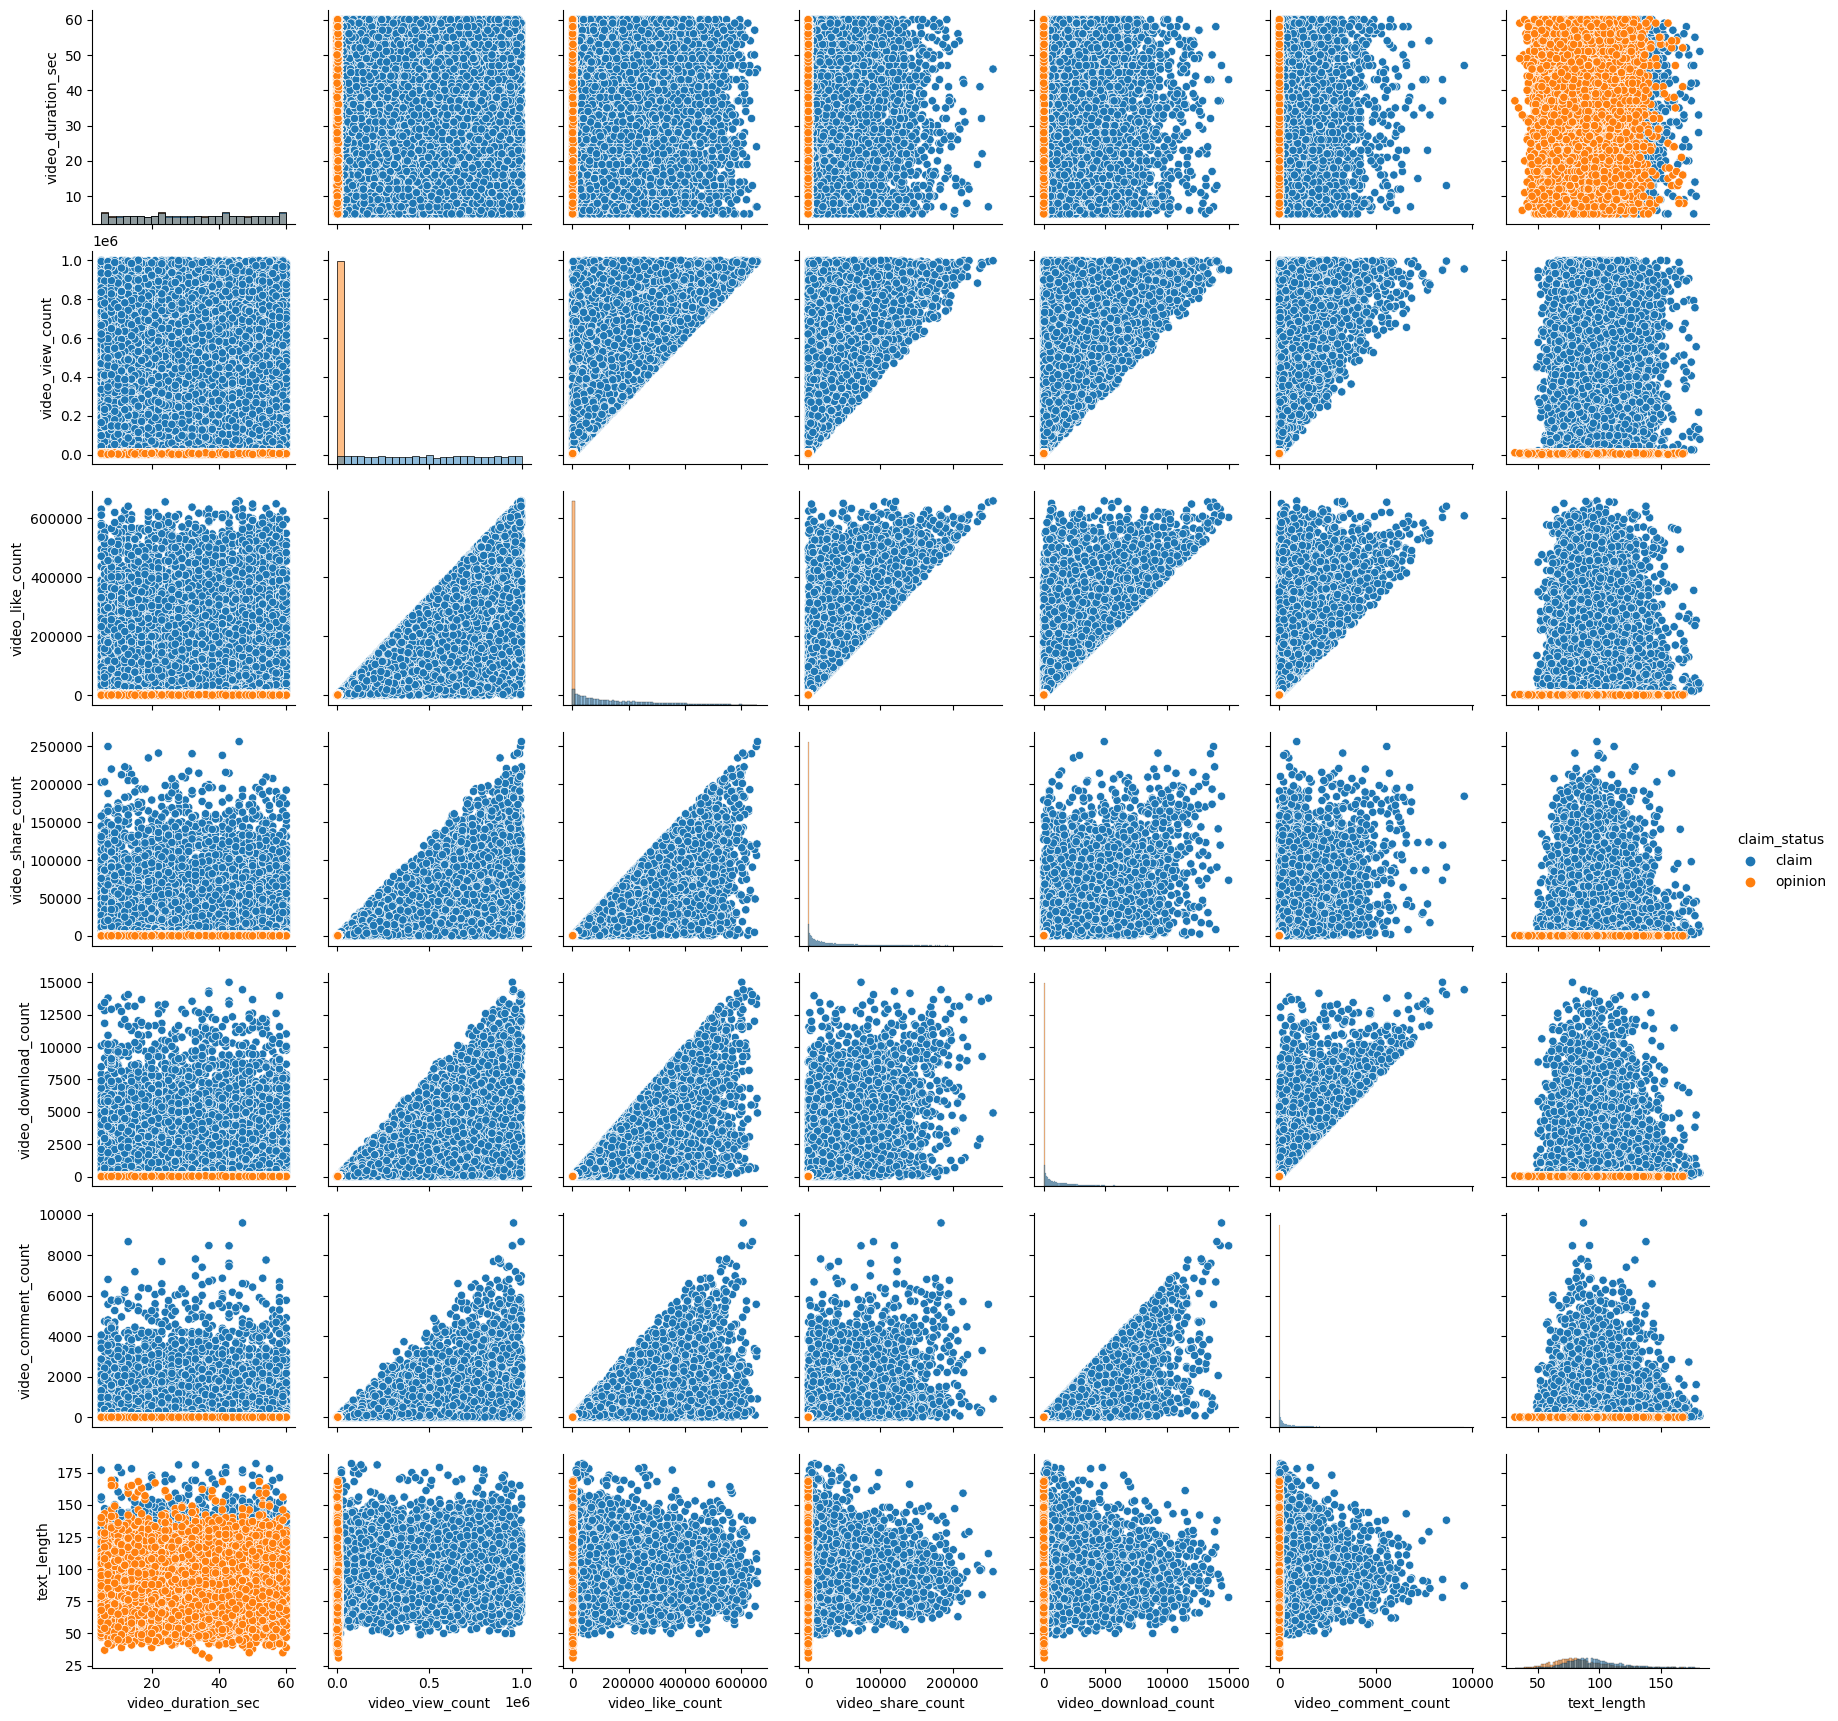

In [12]:
%%time
pp = sns.pairplot(data=data[num_cols+['claim_status']], hue="claim_status", diag_kind="hist")


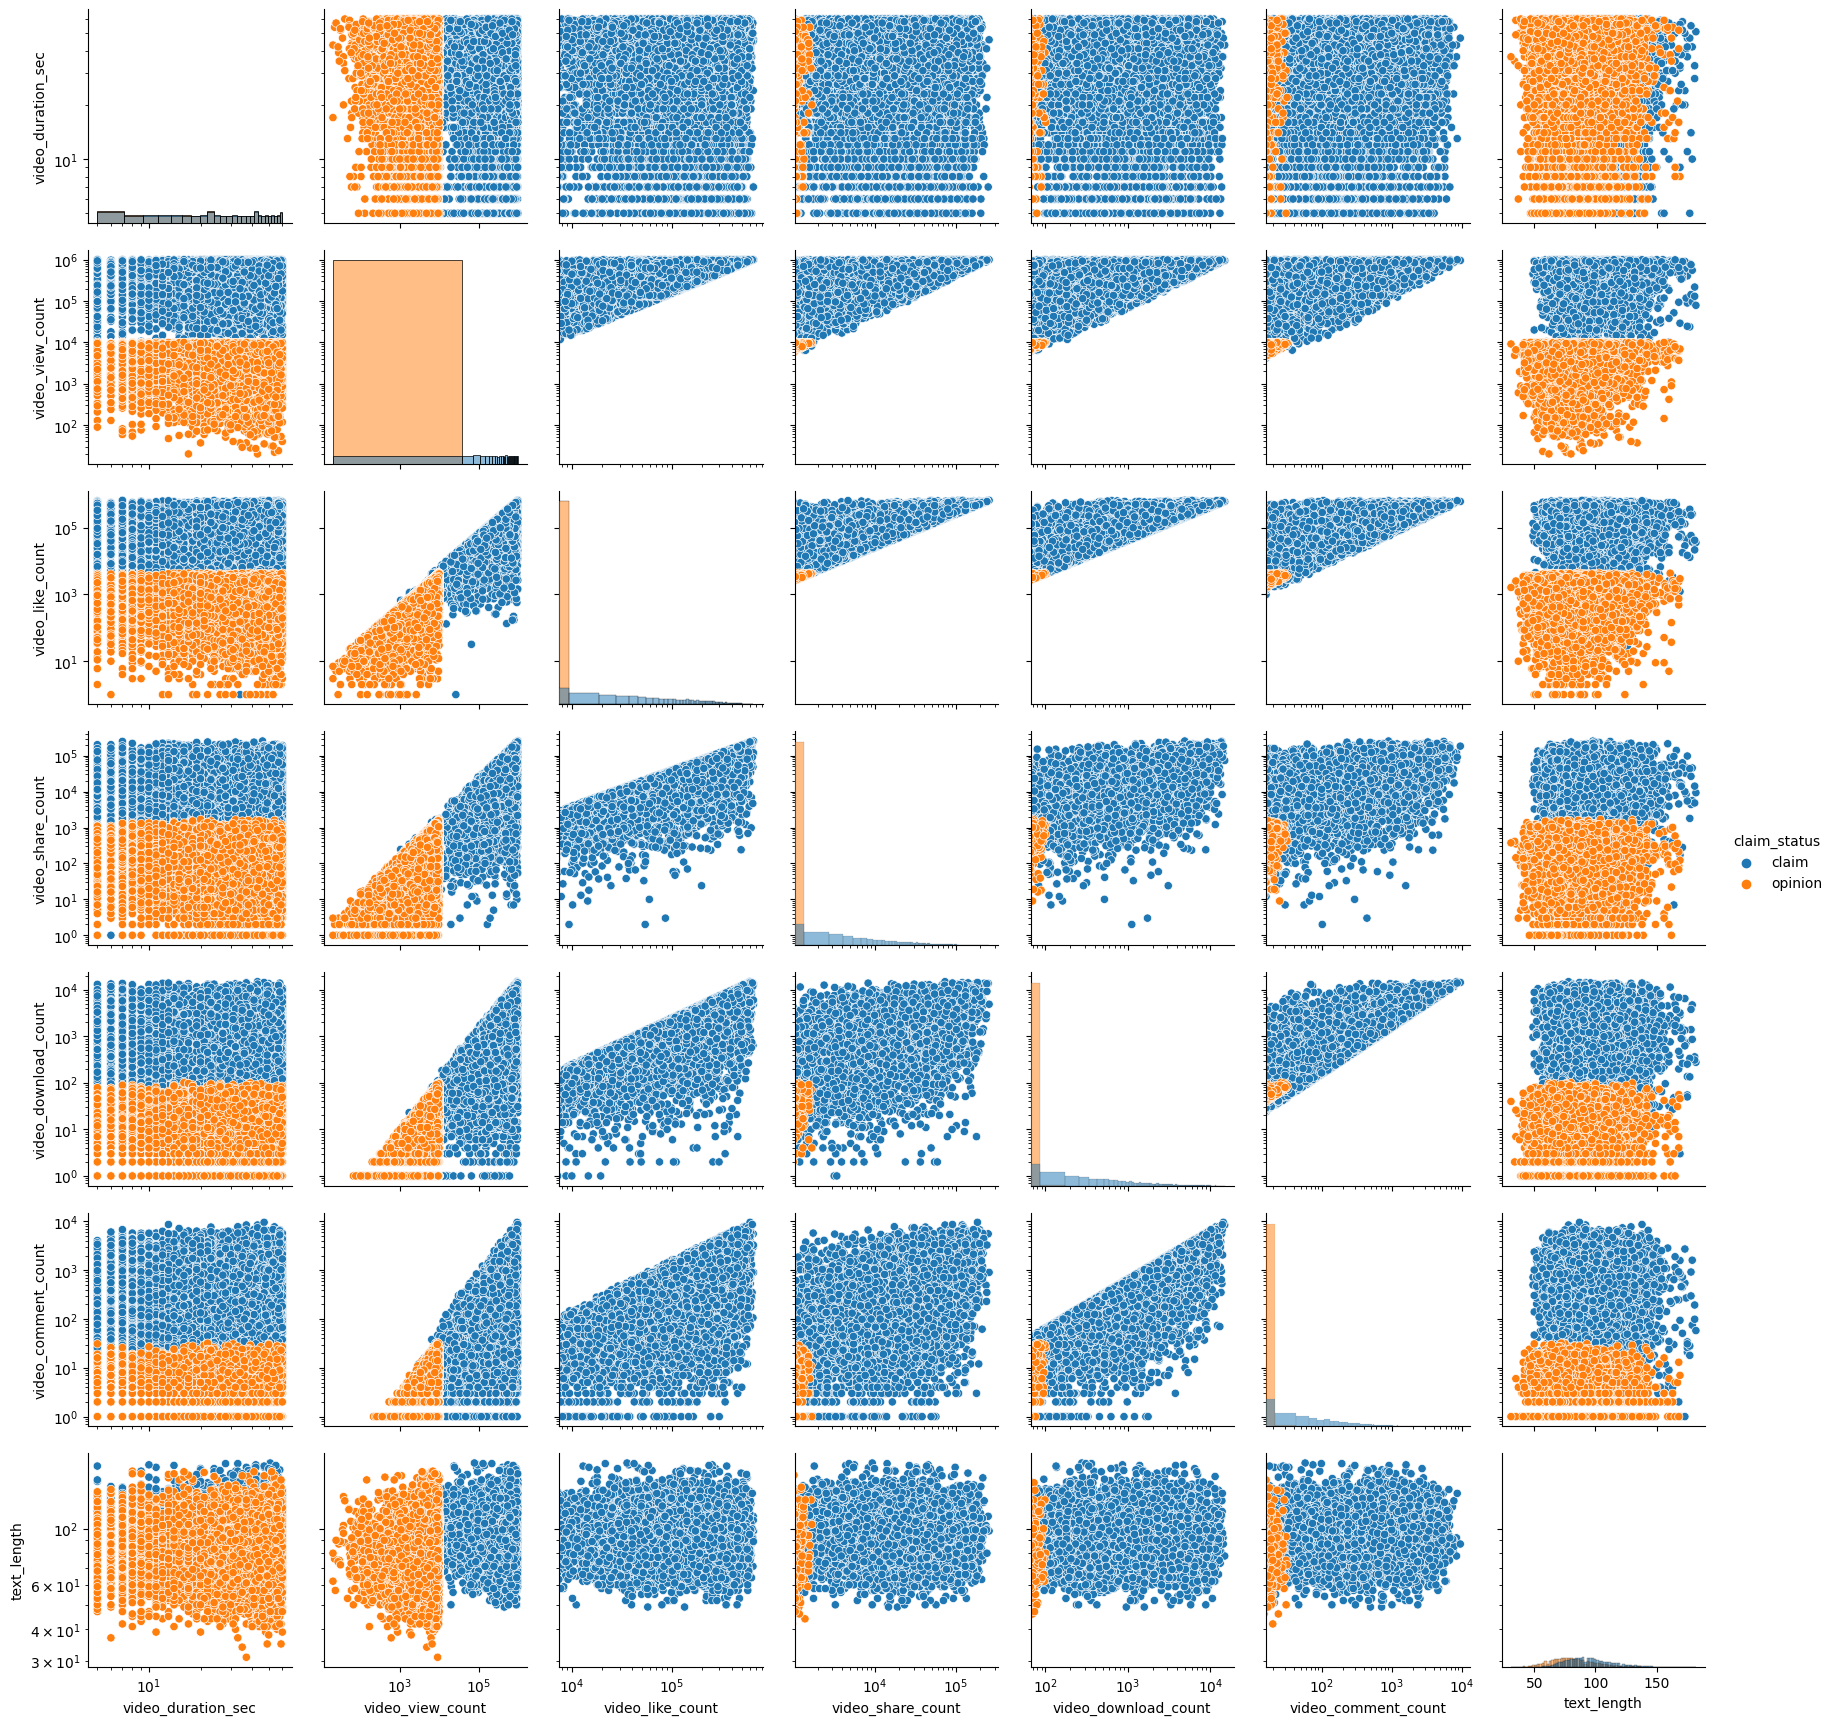

In [13]:
pp = sns.pairplot(data=data[num_cols+['claim_status']], hue="claim_status", diag_kind="hist")

log_columns = num_cols[:-1]

for ax in pp.axes.flat:
    if ax.get_xlabel() in log_columns:
        ax.set(xscale='log', yscale='log')

These plots again show the very different distribution of the claims vs opinions

In [50]:
data.columns

Index(['#', 'claim_status', 'video_id', 'video_duration_sec',
       'video_transcription_text', 'verified_status', 'author_ban_status',
       'video_view_count', 'video_like_count', 'video_share_count',
       'video_download_count', 'video_comment_count', 'text_length'],
      dtype='object')

<Axes: xlabel='author_ban_status,claim_status'>

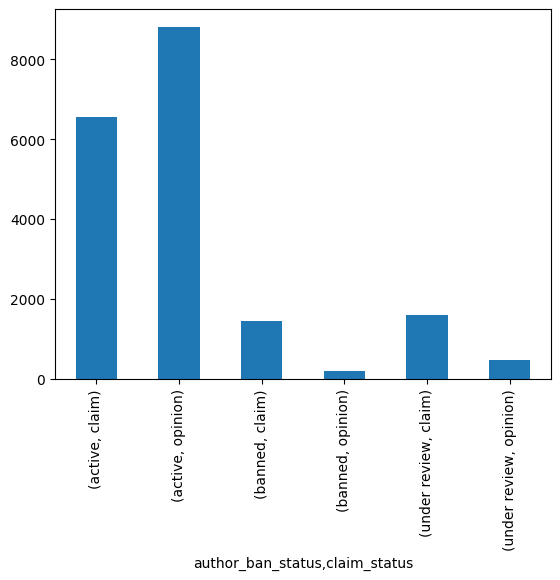

In [60]:
data.groupby(by=['author_ban_status', 'claim_status'])['claim_status'].count().plot(kind='bar')

At This stage we could potentially do some more EDA, but I think we see a clear difference in the properties of the target class. I think our Classifier model should be able to perform pretty well considering this. At least well enough to establish a reasonable baseline that we can return to in future iterations.

### Encode Data
Ideally woudl go back and use OneHotEncoder

In [14]:
# For binary classification, we want our target variable to simply be 1 or 0,
X = data.copy()
X['claim_status'] = data['claim_status'].replace({'opinion': 0, 'claim': 1})

In [15]:

# Drop unnecessary columns
X = X.drop(['#', 'video_id'], axis=1)

# Dummy encode remaining categorical values
X = pd.get_dummies(X,
                   columns=['verified_status', 'author_ban_status'],
                   drop_first=True)
X.columns

Index(['claim_status', 'video_duration_sec', 'video_transcription_text',
       'video_view_count', 'video_like_count', 'video_share_count',
       'video_download_count', 'video_comment_count', 'text_length',
       'verified_status_verified', 'author_ban_status_banned',
       'author_ban_status_under review'],
      dtype='object')

In [16]:
# Isolate target variable
y = X['claim_status']
# Isolate features
X = X.drop(['claim_status'], axis=1)

In [17]:
# Split the data into training and testing sets
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [18]:
# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=0.25, random_state=0)

In [19]:
# Set up a `CountVectorizer` object, which converts a collection of text to a matrix of token counts
count_vec = CountVectorizer(ngram_range=(2, 3),
                            max_features=15,
                            stop_words='english')


count_data = count_vec.fit_transform(X_train['video_transcription_text']).toarray()

# Place the numerical representation of `video_transcription_text` from training set into a dataframe
count_df = pd.DataFrame(data=count_data, columns=count_vec.get_feature_names_out())
# Concatenate `X_train` and `count_df` to form the final dataframe for training data (`X_train_final`)
# Note: Using `.reset_index(drop=True)` to reset the index in X_train after dropping `video_transcription_text`,
# so that the indices align with those in `X_train` and `count_df`
X_train_final = pd.concat([X_train.drop(columns=['video_transcription_text']).reset_index(drop=True), count_df], axis=1)
X_train_final.columns

Index(['video_duration_sec', 'video_view_count', 'video_like_count',
       'video_share_count', 'video_download_count', 'video_comment_count',
       'text_length', 'verified_status_verified', 'author_ban_status_banned',
       'author_ban_status_under review', 'colleague discovered',
       'colleague learned', 'colleague read', 'discovered news',
       'discussion board', 'friend learned', 'friend read', 'internet forum',
       'learned media', 'media claim', 'news claim', 'point view',
       'read media', 'social media', 'willing wager'],
      dtype='object')

In [20]:
## Do the same with Validation set
# Extract numerical features from `video_transcription_text` in the testing set
validation_count_data = count_vec.transform(X_val['video_transcription_text']).toarray()
validation_count_df = pd.DataFrame(data=validation_count_data, columns=count_vec.get_feature_names_out())
X_val_final = pd.concat([X_val.drop(columns=['video_transcription_text']).reset_index(drop=True), validation_count_df], axis=1)


# Extract numerical features from `video_transcription_text` in the testing set
test_count_data = count_vec.transform(X_test['video_transcription_text']).toarray()

# Place the numerical representation of `video_transcription_text` from test set into a dataframe
test_count_df = pd.DataFrame(data=test_count_data, columns=count_vec.get_feature_names_out())

# Concatenate `X_val` and `validation_count_df` to form the final dataframe for training data (`X_val_final`)
X_test_final = pd.concat([X_test.drop(columns=['video_transcription_text']
                                      ).reset_index(drop=True), test_count_df], axis=1)

## Build Models

### Random Forest

In [21]:
# Instantiate the random forest classifier
rf = RandomForestClassifier(random_state=0)

# Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [5, 7, None],
             'max_features': [0.3, 0.6],
            #  'max_features': 'auto'
             'max_samples': [0.7],
             'min_samples_leaf': [1,2],
             'min_samples_split': [2,3],
             'n_estimators': [75,100,200],
             }

# Define a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# Instantiate the GridSearchCV object
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=5, refit='recall')

In [22]:
%%time
rf_cv.fit(X_train_final, y_train)

CPU times: user 7min 16s, sys: 581 ms, total: 7min 17s
Wall time: 7min 26s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [5, 7, None], 'max_features': [0.3, 0.6],
                         'max_samples': [0.7], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3],
                         'n_estimators': [75, 100, 200]},
             refit='recall', scoring={'f1', 'accuracy', 'recall', 'precision'})

In [23]:
print(rf_cv.best_score_, rf_cv.best_params_)

0.9948228253467271 {'max_depth': None, 'max_features': 0.6, 'max_samples': 0.7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


## XGBoost Model

In [24]:
# Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=0)

# Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [4,8,12],
             'min_child_weight': [3, 5],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [300, 500]
             }

# Define a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# Instantiate the GridSearchCV object
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=5, refit='recall')

In [25]:
%%time
xgb_cv.fit(X_train_final, y_train)

CPU times: user 2min 15s, sys: 1.3 s, total: 2min 16s
Wall time: 1min 15s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=0, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [4, 8, 12],
                         'min_child_weight': [3, 5],
                         'n_estimators': [300, 500]},
             refit='recall', scoring={'f1', 'accuracy', 'recall', 'precision'})

In [26]:
print(xgb_cv.best_score_, xgb_cv.best_params_)

0.9898176171763818 {'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 300}


## Evaluate Models

## Random Forest

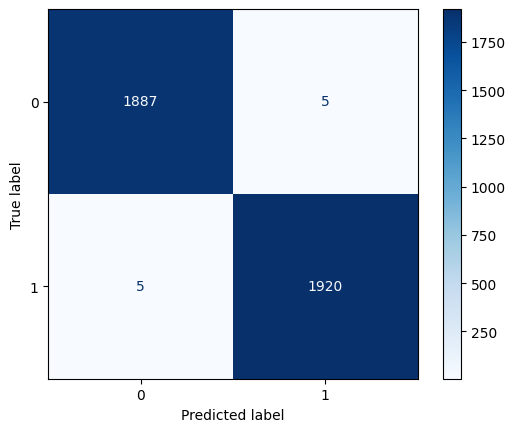

In [45]:
# Use the random forest "best estimator" model to get predictions on the validation set
y_pred = rf_cv.best_estimator_.predict(X_val_final)

# Create a confusion matrix to visualize the results of the classification model

# Compute values for confusion matrix
log_cm = confusion_matrix(y_val, y_pred)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

# Plot confusion matrix
log_disp.plot( cmap='Blues')

# Display plot
plt.show()

In [28]:
# Create a classification report
# Create classification report for random forest model
target_labels = ['opinion', 'claim']
print(classification_report(y_val, y_pred, target_names=target_labels))

              precision    recall  f1-score   support

     opinion       1.00      1.00      1.00      1892
       claim       1.00      1.00      1.00      1925

    accuracy                           1.00      3817
   macro avg       1.00      1.00      1.00      3817
weighted avg       1.00      1.00      1.00      3817



## XGBoost


In [29]:
#Evaluate XGBoost model
y_pred = xgb_cv.best_estimator_.predict(X_val_final)

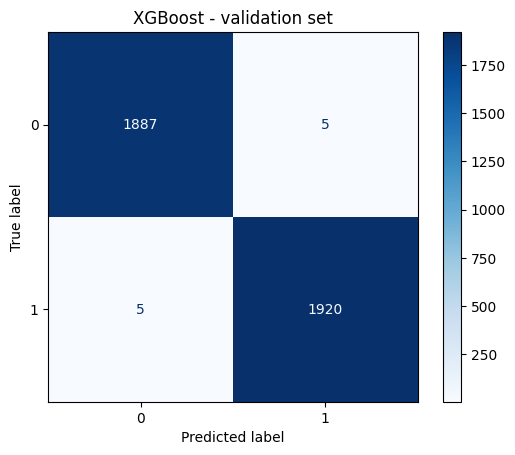

In [46]:
# Compute values for confusion matrix
log_cm = confusion_matrix(y_val, y_pred)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm,display_labels=None)

# Plot confusion matrix
log_disp.plot( cmap='Blues')

# Display plot
plt.title('XGBoost - validation set');
plt.show()


In [32]:
# Create a classification report
target_labels = ['opinion', 'claim']
print(classification_report(y_val, y_pred, target_names=target_labels))

              precision    recall  f1-score   support

     opinion       0.99      1.00      0.99      1892
       claim       1.00      0.99      0.99      1925

    accuracy                           0.99      3817
   macro avg       0.99      0.99      0.99      3817
weighted avg       0.99      0.99      0.99      3817



### Continue with best model (RF)

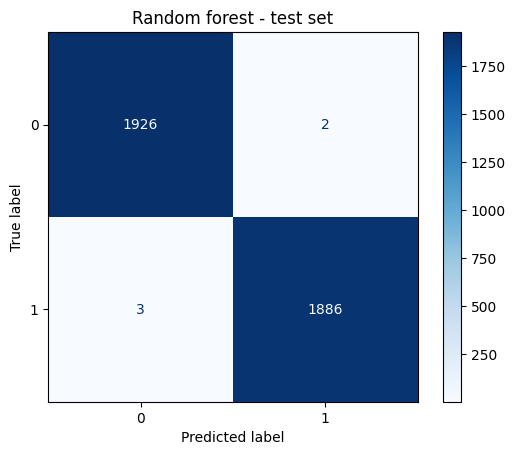

In [47]:
# Use champion model to predict on test data
y_pred = rf_cv.best_estimator_.predict(X_test_final)

# Compute values for confusion matrix
log_cm = confusion_matrix(y_test, y_pred)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm,  display_labels=None)

# Plot confusion matrix
log_disp.plot( cmap='Blues')

# Display plot
plt.title('Random forest - test set');
plt.show()

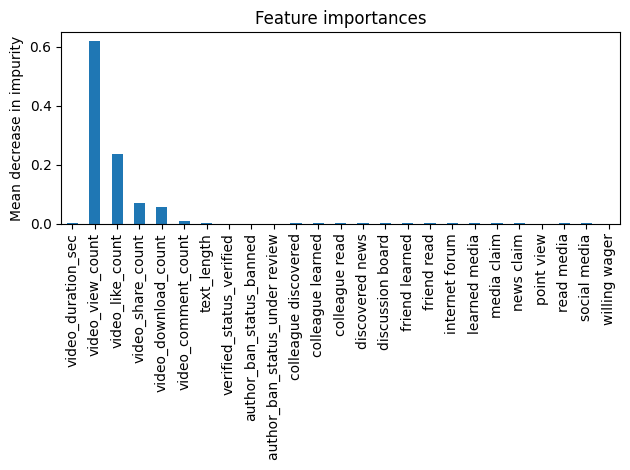

In [34]:
# Feature importances

importances = rf_cv.best_estimator_.feature_importances_
rf_importances = pd.Series(importances, index=X_test_final.columns)

fig, ax = plt.subplots()
rf_importances.plot.bar(ax=ax)
ax.set_title('Feature importances')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout()